# Flow Visualization

In [1]:
from argparse import Namespace
from copy import deepcopy
import random

from matplotlib import pyplot as plt
import matplotlib.colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import torch as th
import torch.nn.functional as F

from lib.augmentation import FlowNetAugmentation
from lib.datasets.flow.flyingchairs import FlyingChairsTrain
from lib.datasets.flow.flyingthings3d import FlyingThings3DTrain
from lib.datasets.flow.sintel import SintelTrain, SintelTest
from lib.utils import get_checkpoint, warp
from lib.flownet import FlowNetC, FlowNetS
from eval import restore, sample_to_device
from lib.metrics import compute_flow_metrics

## Plotting code

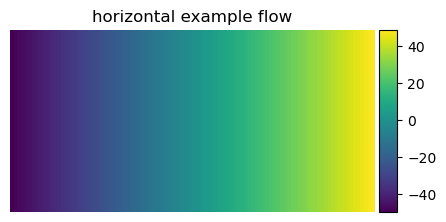

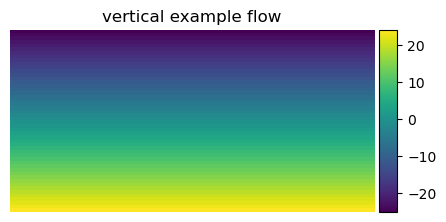

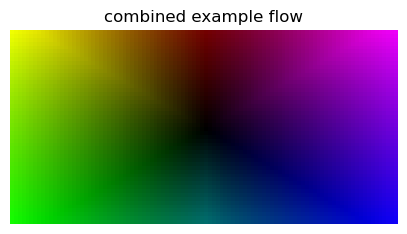

In [2]:
def add_colorbar(fig, fig_imshow, ax):
    """Add colorbar to a given figure"""
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(fig_imshow, cax=cax)
    
    
def view_image(image, title="untitled", figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    plt.title(title)
    fig_imshow = plt.imshow(image)
    ax = fig.get_axes()[0]
    if image.ndim == 2:
        # automatically add a colorbar for data with 2 dimensions (i.e. not RGB)
        add_colorbar(fig, fig_imshow, ax)
    ax.set_axis_off()
    plt.show()

    
def visualize_flow(flow, title="untitled", figsize=(10, 10)):
    """
    Based on:
        https://stackoverflow.com/questions/28898346/visualize-optical-flow-with-color-model
        https://stackoverflow.com/questions/73554127/converting-cartesian-coordinates-to-polar-coordinates-with-numpy
    """
    # input H, W, 2
    h, w, _ = flow.shape
    
    # convert flow to polar coordinates
    v, u = flow[..., 0], flow[..., 1]
    radius = np.sqrt(v ** 2 + u ** 2)
    angle = np.arctan2(v, u)
    
    # normalize radius to [0, 1]
    radius_norm = radius / np.max(radius)
    
    # angle is given in range -pi to pi, normalize to [0, 1]
    angle_norm = (angle / 2 / np.pi + 0.5)
    
    # use angle as hue (color tone) and radius as value (brightness), with full saturation
    hsv = np.zeros((h, w, 3), dtype=np.float32)
    hsv[..., 0] = angle_norm
    hsv[..., 1] = 1.
    hsv[..., 2] = radius_norm
    
    # convert to rgb and plot
    rgb = matplotlib.colors.hsv_to_rgb(hsv)
    view_image(rgb, title=title, figsize=figsize)

    
# create example flow that points away from the center
ex_h, ex_w = 50, 100
scale = 1
us = np.linspace(-ex_w/2, ex_w/2-1, ex_w) * scale
vs = np.linspace(-ex_h/2, ex_h/2-1, ex_h) * scale
u, v = np.meshgrid(us, vs)

ex_flow = np.zeros((ex_h, ex_w, 2), dtype=np.float32)
ex_flow[..., 0] = u
ex_flow[..., 1] = v

view_image(ex_flow[..., 0], "horizontal example flow", (5, 5))
view_image(ex_flow[..., 1], "vertical example flow", (5, 5))
visualize_flow(ex_flow, "combined example flow", (5, 5))


## Create and view train dataset

In [3]:
# fix seed so the augmentation stays the same
seed = 1
th.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

def create_train_dataloader(dset_name):
    if dset_name == 'FlyingThings3D':
        dataset_cls = FlyingThings3DTrain
    elif dset_name == 'FlyingChairs':
        dataset_cls = FlyingChairsTrain
    elif dset_name == 'Sintel':
        dataset_cls = SintelTrain
    else:
        raise ValueError(f"Unknown dataset: {dset_name}")
    aug_fct = FlowNetAugmentation()
    dataloader = dataset_cls.init_as_loader(
        batch_size=1, shuffle=False, num_workers=0, pin_memory=False, drop_last=False,
        aug_fcts=aug_fct)
    return dataloader

dataloader = create_train_dataloader("Sintel")
train_sample = None
for train_sample in dataloader:
    break
assert train_sample is not None


Initializing dataset SintelTrain from /misc/lmbssd/gings/cv_shared_data/Sintel/data/training.
	Initializing samples from list at /misc/lmbssd/gings/cv_shared_data/Sintel/sample_lists/flow.SintelTrain.pickle.
	Number of samples: 943
Finished initializing dataset SintelTrain.



Meta information
    _base:/misc/lmbssd/gings/cv_shared_data/Sintel/data/training
    _name:ambush_2/key0001
    _keyview_idx:0
    _index:0
    _dataset:SintelTrain
    _orig_height:436
    _orig_width:1024
    _spatial_aug_scaled_height:575
    _spatial_aug_scaled_width:1350
    _spatial_aug_crop_y:8
    _spatial_aug_crop_x:431


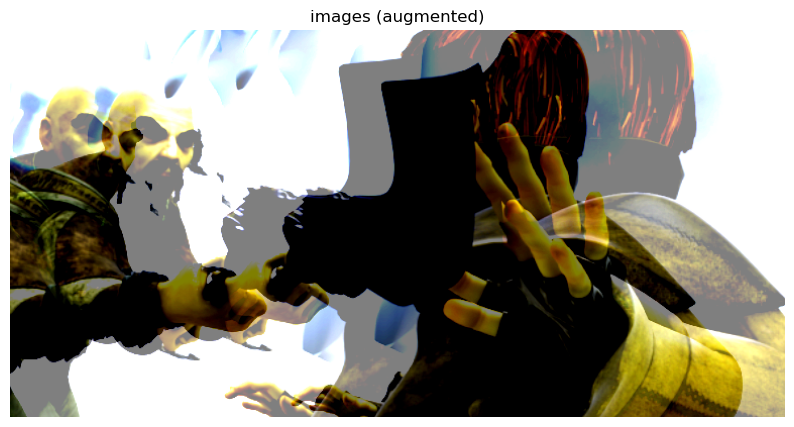

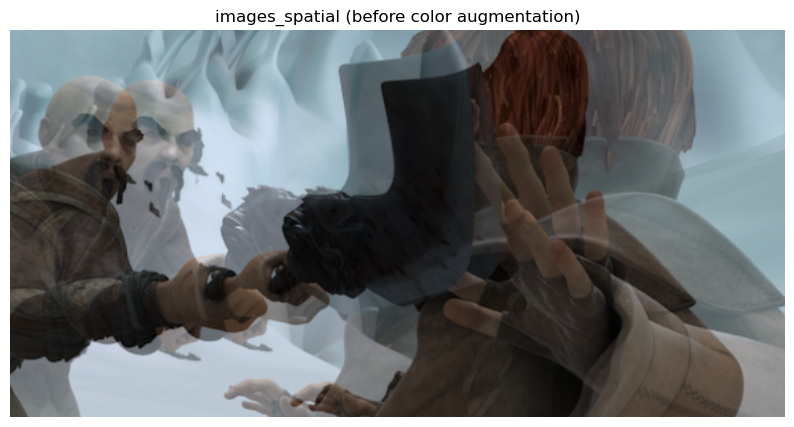

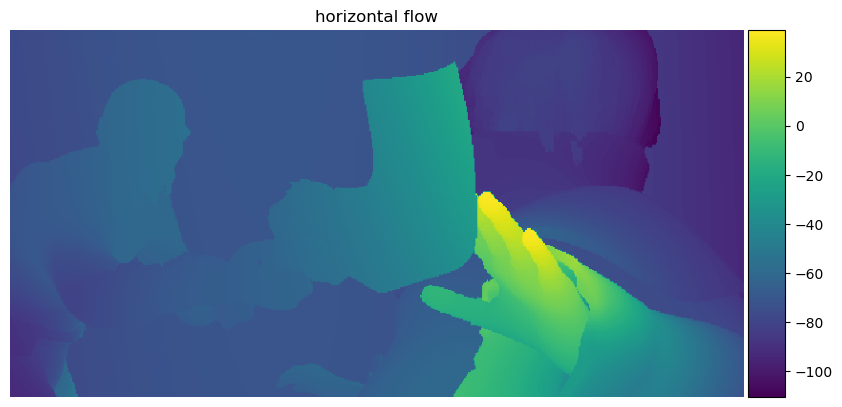

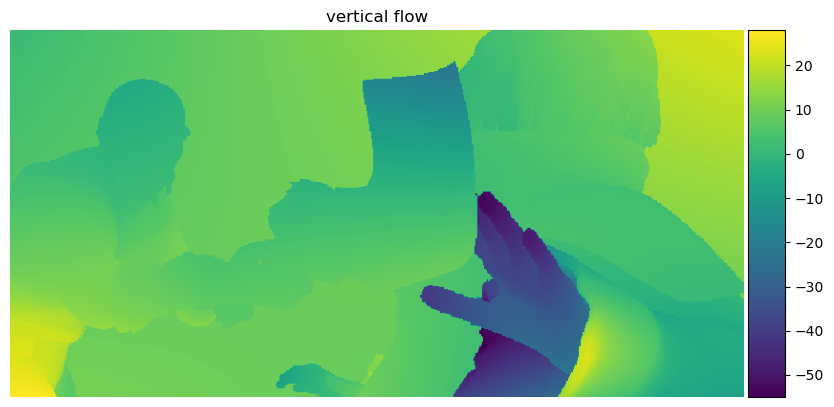

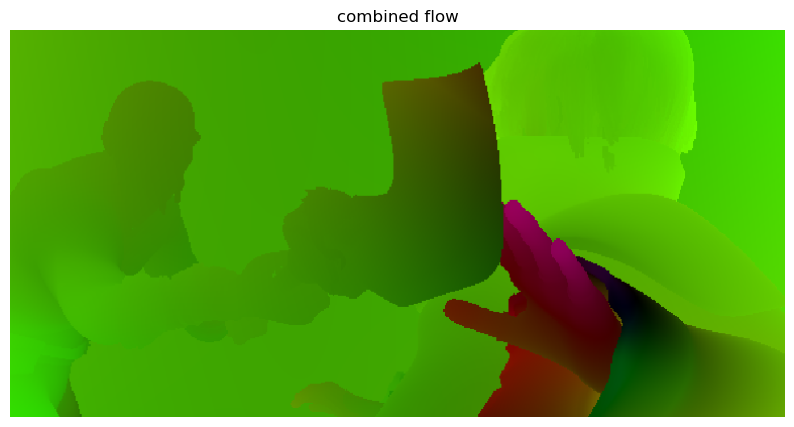

In [4]:
def convert_image_to_numpy(image_torch):
    # convert torch (C, H, W) to numpy / matplotlib (H, W, C)
    return np.transpose(image_torch.detach().cpu().numpy(), (1, 2, 0))

def convert_image_list(image_list, batch_idx=0, overlay=True):
    # input is list of [B, 3, H, W]
    image_list_nobatch = [image[batch_idx] for image in image_list]
    if overlay:
        # overlay images on top of each other
        images_stacked = (image_list_nobatch[0] + image_list_nobatch[1]) / 2
    else:
        # stack images vertically
        images_stacked = th.cat([image_list_nobatch[0], image_list_nobatch[1]], axis=1)
    images_np = convert_image_to_numpy(images_stacked)
    return images_np

def view_sample(sample, batch_idx=0, overlay=True, view_separate_flow=True):
    batch_idx = 0
    sample_copy = deepcopy(sample)
    print(f"Meta information")
    for k in list(sample_copy.keys()):
        if k[0] == "_":
            v = sample_copy.pop(k)[batch_idx]
            print(f"    {k}:{v}")

    images = sample_copy.pop("images")
    images_np = convert_image_list(images)
    # images is in range (-0.4 to 0.6), undo the normalization
    images_np += 0.4
    view_image(images_np, "images (augmented)")

    images_spatial = sample_copy.pop("images_spatial")
    images_spatial_np = convert_image_list(images_spatial)
    # images_spatial is in range (0, 255)
    images_spatial_np /= 255.
    view_image(images_spatial_np, "images_spatial (before color augmentation)")

    gt_flow = sample_copy.pop("gt_flow")  # (B, 2, H, W)
    gt_flow_nobatch = gt_flow[batch_idx]
    gt_flow_np = convert_image_to_numpy(gt_flow_nobatch)
    if view_separate_flow:
        view_image(gt_flow_np[..., 0], "horizontal flow")
        view_image(gt_flow_np[..., 1], "vertical flow")
    visualize_flow(gt_flow_np, "combined flow")

view_sample(train_sample)

## Create and view test dataset

Initializing dataset SintelTest from /misc/lmbssd/gings/cv_shared_data/Sintel/data/training.
	Initializing samples from list at /misc/lmbssd/gings/cv_shared_data/Sintel/sample_lists/flow.SintelTest.pickle.
	Number of samples: 98
Finished initializing dataset SintelTest.

Meta information
    _base:/misc/lmbssd/gings/cv_shared_data/Sintel/data/training
    _name:alley_1/key0001
    _keyview_idx:0
    _index:0
    _dataset:SintelTest
    _orig_height:436
    _orig_width:1024
    _spatial_aug_scaled_height:448
    _spatial_aug_scaled_width:1024
    _spatial_aug_crop_y:0
    _spatial_aug_crop_x:0


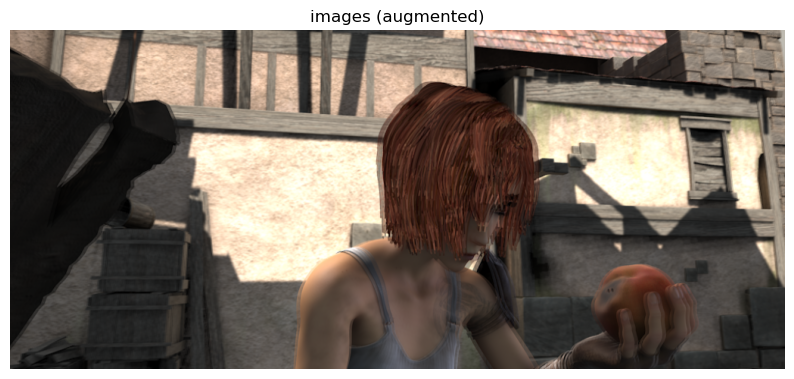

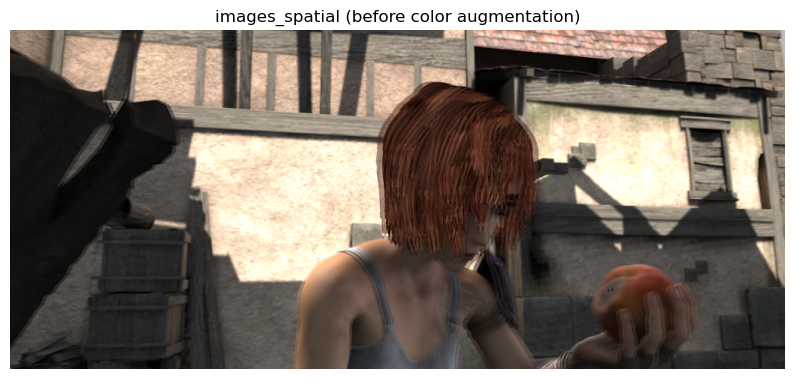

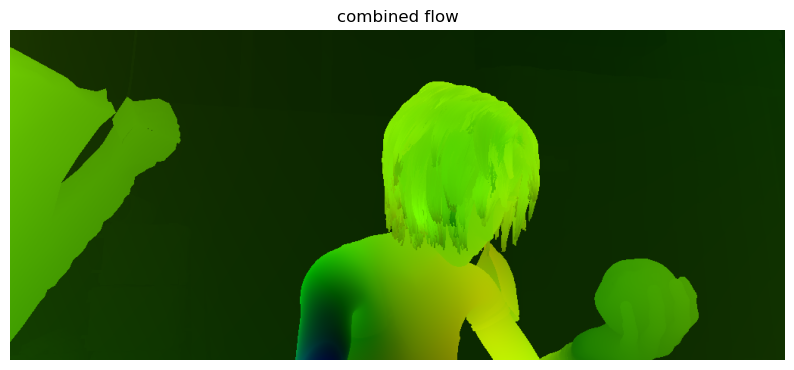

In [5]:
def create_test_dataloader(dset_name):
    if dset_name == 'FlyingThings3D':
        dataset_cls = FlyingThings3DTest
    elif dset_name == 'FlyingChairs':
        dataset_cls = FlyingChairsTest
    elif dset_name == 'Sintel':
        dataset_cls = SintelTest
    elif dset_name == 'SintelFull':
        dataset_cls = SintelFullTrain
    else:
        raise ValueError(f"Unknown dataset {dset_name}")

    preprocess_fct = FlowNetAugmentation()
    preprocess_fct.out_size = None  # upscale to next height and width that are divisible by 64
    preprocess_fct.spatial_aug_prob = 0.  # only resize, no cropping
    preprocess_fct.color_aug_prob = 0.  # no color augmentation
    preprocess_fct.augment_image_only = True  # do not resize the ground truth
    dataloader = dataset_cls.init_as_loader(
            batch_size=1, shuffle=False, num_workers=0, pin_memory=False,
            drop_last=False, aug_fcts=preprocess_fct)
    return dataloader

test_dataloader = create_test_dataloader("Sintel")
test_sample = None
for test_sample in test_dataloader:
    break
assert test_sample is not None

view_sample(test_sample, view_separate_flow=False)

## Load and run model

In [6]:
device = "cuda"

def setup_model(model_name="FlowNetS", C=48, cuda_corr=False, device="cuda"):
    if model_name == 'FlowNetC':
        model = FlowNetC(C=C, cuda_corr=cuda_corr)
    elif model_name == 'FlowNetS':
        model = FlowNetS(C=C)
    else:
        raise ValueError(f"Unknown model: {model_name}")
    model = model.to(device)
    model.eval()

    return model

model = setup_model(device=device)
ckpt_path = get_checkpoint("pt/flownets")
restore(model, ckpt_path)

Restoring model weights from /misc/lmbssd/gings/cv_shared_data/OpticalFlowPretrainedModels/flownet_s/checkpoint-model-iter-000600000.pt



In [7]:
def run_model(model, sample):
    image_list = sample['images']
    image_1 = image_list[0]
    image_2 = image_list[1]
    model_output_dict = model(image_1, image_2)
    return model_output_dict

test_sample_device = sample_to_device(test_sample, device)
model_output_dict = run_model(model, test_sample_device)
model_output_dict.keys()

dict_keys(['pred_flows_all', 'pred_flow'])

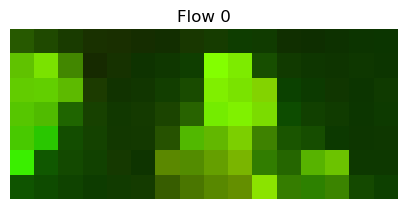

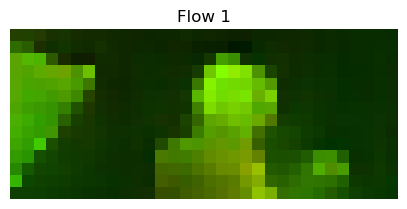

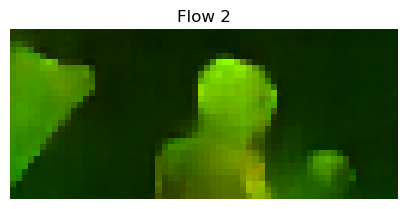

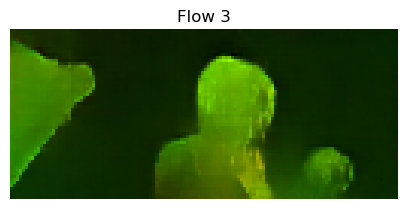

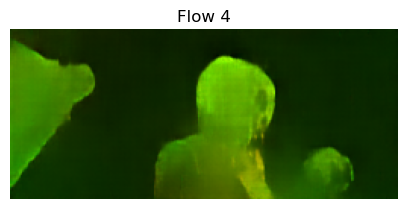

In [8]:
for i, flow in enumerate(model_output_dict["pred_flows_all"]):
    flow = flow[0]
    flow_np = convert_image_to_numpy(flow)
    visualize_flow(flow_np, f"Flow {i}", figsize=(5,3))
    

## Compute metrics

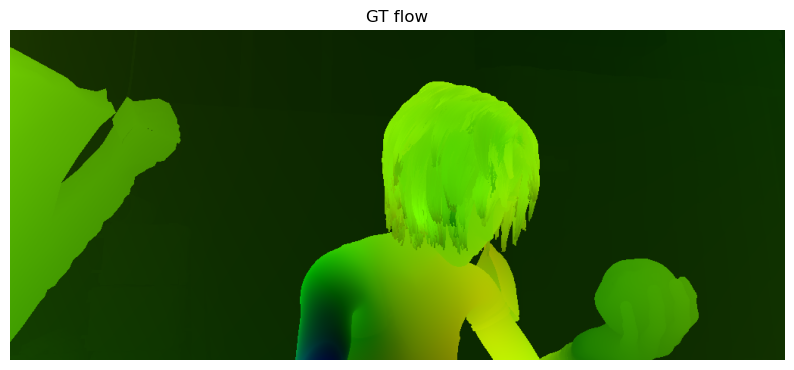

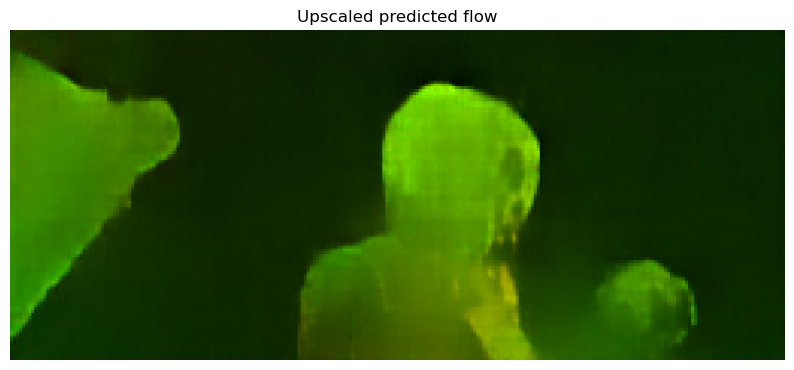

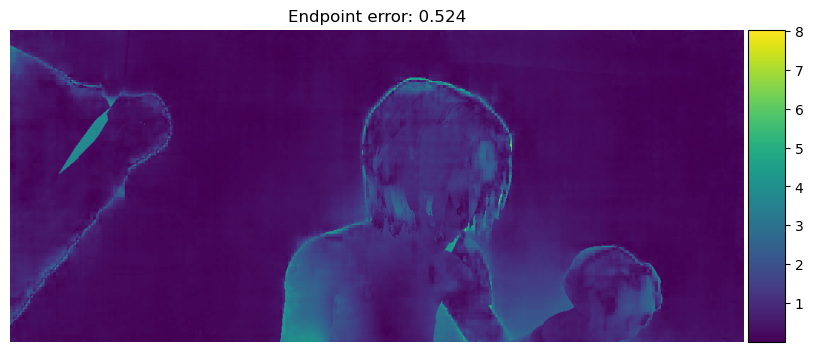

In [9]:
metrics, qualitatives = compute_flow_metrics(test_sample_device, model_output_dict)
epe_np = convert_image_to_numpy(qualitatives["epe"][0]).squeeze(-1)
scaled_pred_np = convert_image_to_numpy(qualitatives["pred_flow"][0])
gt_flow_np = convert_image_to_numpy(test_sample["gt_flow"][0])

visualize_flow(gt_flow_np, f"GT flow")
visualize_flow(scaled_pred_np, f"Upscaled predicted flow")
view_image(epe_np, f"Endpoint error: {metrics['aepe']:.3g}")